# <div class='alert alert-block alert-success'>COMP 642 Final Project - Part 2</div>

<div class='alert alert-block alert-info'>
Data:  Prepare a data analysis report that includes:

- Data definition for each parameter including measurement units

- Plan for missing data for each parameter (if needed)

- Plan for additional parameters or data (if needed)

- Any transformations necessary

- Plan for separating

- Visualization of data if possible
</div>

# <div class='alert alert-block alert-success'> Data Definitions </div>

### Summary

We will explore some features and data which will be considered for use in our project. 

It may be best to redefine our goal. We are attempting to determine, based on daily or weekly market close prices of TQQQ, whether the following day or week will yield a gain or a loss. Depending on that, we will decide to long (buy) or short (sell) TQQQ for the upcoming week/day. There are many factors that could influence this. TQQQ is a 3x leveraged ETF of the Nasdaq Composite. Major movements in large cap stocks, mostly centered toward technology stocks, are the major influencers of the price movements in this product. These large cap companies are also heavily influenced by outside economic factors that are not entirely dependent on company performance/financials. Also, there are technical techniques lightly used in the investment industry that may allow more insight into possible future movements of secuirty prices. These techniques are related to historical price movements and trade volumes. Armed with this observation, we can make some general assumptions for data required for our analysis and our model.

---

1. Macro market factors that influence stock prices
    - Interest rates
    - Inflation
    - Currency
    - Market Volitility (Fear Gauge)
    - Commodities

2. Technical Indicators
    - 35 day price exponential moving average
    - 200 day price moving average
    - Volume
    - Moving Average Convergence Divergence (MACD)
    - Relative Strength Index (RSI)

---

### Part 1

We will be using some readily available ETF data which tracks each of these macro economic features. 

**Interest Rates** = ProShares Short 20+ Year Treasury ETF: Ticker TBF

**Inflation** = iShares TIPS Bond ETF: Ticker TIP

**Currency** = Invesco DB US Dollar Index Bullish Fund: Ticker UUP

**Market Volitility** =  ProShares VIX Short-Term Futures ETF: Ticker VIXY

**Commodities** = United States Oil Fund: Ticker USO

**Commodities** = SPDR Gold Shares: Ticker GLD

---

### Part 2

We will be conducting feature engineering of the daily close price data in order to construct features that make 4 of the indicators;

35 day price exponential moving average: ema_35

200 day simple moving average: sma_200

Moving Average Convergence Divergence (MACD): macd

Relative Strength Index (RSI): rsi

We will also track purchase volume (vol) and we may need to convert the price data into percentages gained or loss from the previous day close depending on how we would like to visualize the data and/or make predictions.

--- 

Finally we will feature engineer our dependent variable. This depending variable will be the next day/week closing price. We will also create a binary categorical variable to indicate long or short depending on if the next day/week closing price is greater than the current day/week closing price

In [91]:
# import required packages
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [102]:
# fetching adjusted close price, volume, and percent changes
tqqq_price = yf.download('TQQQ', start='2010-12-31', end='2024-02-29', group_by='ticker')[['Adj Close', 'Volume']]
tqqq_price['TQQQ Daily Returns'] = tqqq_price['Adj Close'].pct_change()

tbf_price = pd.DataFrame(yf.download('TBF', start='2010-12-31', end='2024-02-29')['Adj Close'])
tbf_price['TBF Daily Returns'] = tbf_price['Adj Close'].pct_change()
tbf_price.rename(columns={'Adj Close': 'TBF Adj Close'}, inplace=True)

tip_price = pd.DataFrame(yf.download('TIP', start='2010-12-31', end='2024-02-29')['Adj Close'])
tip_price['TIP Daily Returns'] = tip_price['Adj Close'].pct_change()

uup_price = pd.DataFrame(yf.download('UUP', start='2010-12-31', end='2024-02-29')['Adj Close'])
uup_price['UUP Daily Returns'] = uup_price['Adj Close'].pct_change()

vixy_price = pd.DataFrame(yf.download('VIXY', start='2010-12-31', end='2024-02-29')['Adj Close'])
vixy_price['VIXY Daily Returns'] = vixy_price['Adj Close'].pct_change()

uso_price = pd.DataFrame(yf.download('USO', start='2010-12-31', end='2024-02-29')['Adj Close'])
uso_price['USO Daily Returns'] = uso_price['Adj Close'].pct_change()

gld_price = pd.DataFrame(yf.download('GLD', start='2010-12-31', end='2024-02-29')['Adj Close'])
gld_price['GLD Daily Returns'] = gld_price['Adj Close'].pct_change()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x130998820>
[*********************100%%**********************]  1 of 1 completed


/var/folders/hw/f8pnpzm163q0j3yww182vmgm0000gn/T/ipykernel_84267/1107437381.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tqqq_price['TQQQ Daily Returns'] = tqqq_price['Adj Close'].pct_change()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecat

In [103]:
tbf_price
# tip_price
# uup_price
# vixy_price
# uso_price
# pd.DataFrame(gld_price)
# tqqq_price

,TBF Adj Close,TBF Daily Returns
Date,,
2010-12-31,40.828968,NaN
2011-01-03,40.875099,0.001130
2011-01-04,40.865883,-0.000225
2011-01-05,41.751663,0.021675
2011-01-06,41.576347,-0.004199
...,...,...
2024-02-22,23.780001,-0.002517
2024-02-23,23.440001,-0.014298
2024-02-26,23.530001,0.003840


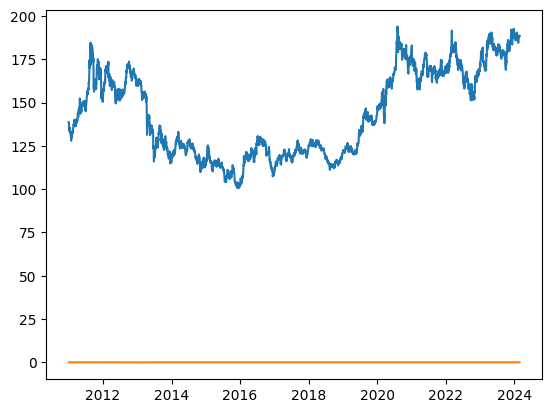

In [104]:
plt.plot(gld_price.index, gld_price)
plt.show()

In [31]:
df_tqqq = pd.DataFrame(tqqq_price)
df_tqqq.reset_index(inplace=True)

In [32]:
df_tqqq.head()

,Date,Adj Close,Volume,Daily Returns
0,2010-12-31,0.751533,24364800,NaN
1,2011-01-03,0.785481,66758400,0.045172
2,2011-01-04,0.784261,65760000,-0.001553
3,2011-01-05,0.803726,61440000,0.024819
4,2011-01-06,0.810993,52262400,0.009042


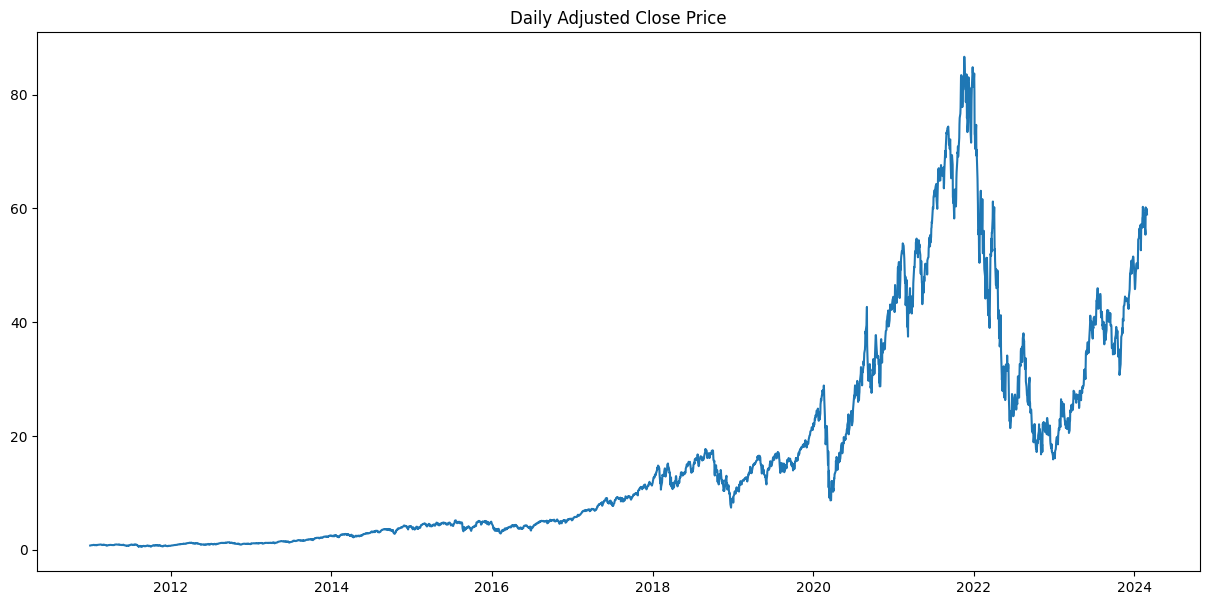

In [39]:
plt.figure(figsize=(15,7))
plt.plot(df_tqqq.iloc[:, 0], df_tqqq.iloc[:, 1])
plt.title('Daily Adjusted Close Price')
plt.show()

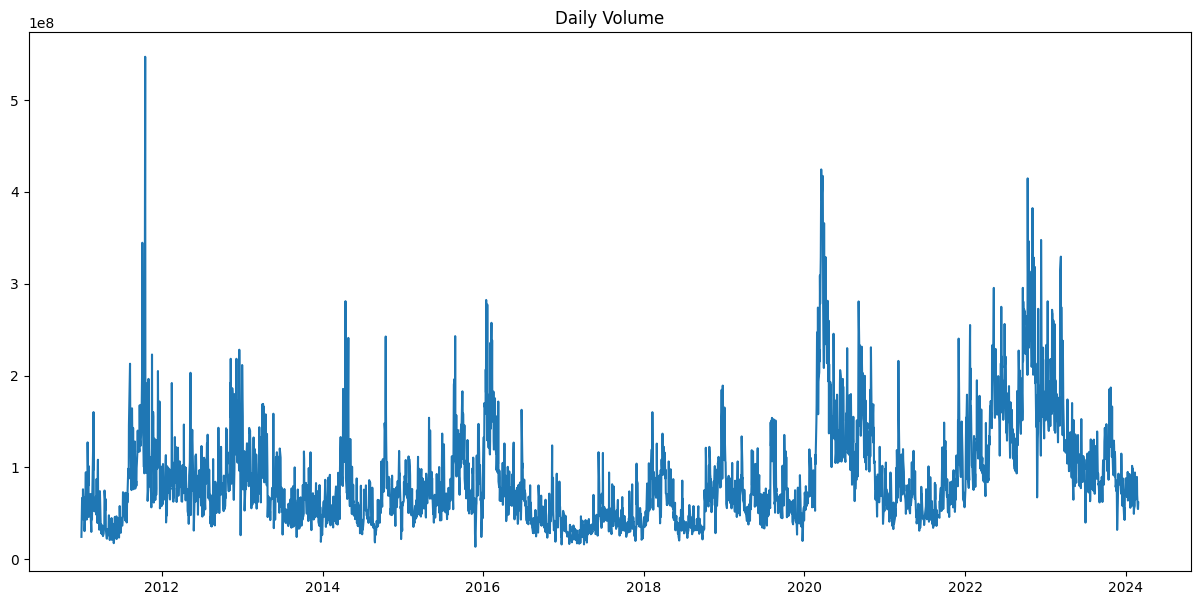

In [41]:
plt.figure(figsize=(15,7))
plt.plot(df_tqqq.iloc[:, 0], df_tqqq.iloc[:, 2])
plt.title('Daily Volume')
plt.show()

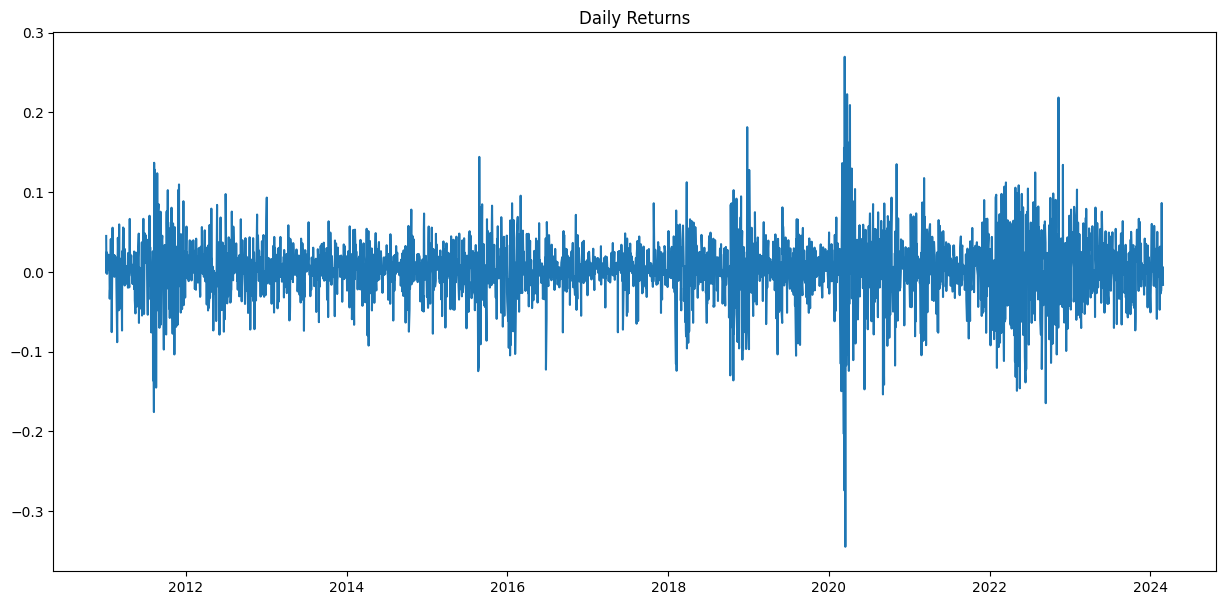

In [42]:
plt.figure(figsize=(15,7))
plt.plot(df_tqqq.iloc[:, 0], df_tqqq.iloc[:, 3])
plt.title('Daily Returns')
plt.show()

In [2]:
import requests
import json
import ssl; ssl._create_default_https_context = ssl._create_stdlib_context

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# get historical stock data
tickers_url = 'https://www.sec.gov/files/company_tickers.json'

# http get request to url
response = requests.get(tickers_url, headers=headers)
# response = requests.get(tickers_url)

# check if successful request
if response.status_code == 200:
    ticker_data = response.json()

    print(ticker_data)
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


{'0': {'cik_str': 789019, 'ticker': 'MSFT', 'title': 'MICROSOFT CORP'}, '1': {'cik_str': 320193, 'ticker': 'AAPL', 'title': 'Apple Inc.'}, '2': {'cik_str': 1045810, 'ticker': 'NVDA', 'title': 'NVIDIA CORP'}, '3': {'cik_str': 1018724, 'ticker': 'AMZN', 'title': 'AMAZON COM INC'}, '4': {'cik_str': 1652044, 'ticker': 'GOOGL', 'title': 'Alphabet Inc.'}, '5': {'cik_str': 1326801, 'ticker': 'META', 'title': 'Meta Platforms, Inc.'}, '6': {'cik_str': 1067983, 'ticker': 'BRK-B', 'title': 'BERKSHIRE HATHAWAY INC'}, '7': {'cik_str': 59478, 'ticker': 'LLY', 'title': 'ELI LILLY & Co'}, '8': {'cik_str': 1046179, 'ticker': 'TSM', 'title': 'TAIWAN SEMICONDUCTOR MANUFACTURING CO LTD'}, '9': {'cik_str': 1730168, 'ticker': 'AVGO', 'title': 'Broadcom Inc.'}, '10': {'cik_str': 1318605, 'ticker': 'TSLA', 'title': 'Tesla, Inc.'}, '11': {'cik_str': 1403161, 'ticker': 'V', 'title': 'VISA INC.'}, '12': {'cik_str': 353278, 'ticker': 'NVO', 'title': 'NOVO NORDISK A S'}, '13': {'cik_str': 19617, 'ticker': 'JPM', '